# Investigate snowfall and snow height on sea ice

In [1]:
#!/usr/bin/env python
# coding: utf-8

import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from sklearn.decomposition import PCA
# from sklearn.model_selection import TimeSeriesSplit
import yaml
import pickle as pkl

from src.data_preparation import mdl_dataset

# from src.modelling import model_ridge
# from src.modelling import model_rf
# from src.modelling import model_grdbst
# from src.modelling import model_xgboost
# from src.modelling import super_model_ml

# from src.modelling import mdl_input_dico  # input variables class
# from src.modelling import mdl_params  # parameters class
# from src.modelling import mdl_history

# from src.visualization import visualize_pca
# from src.visualization.time_serie_split import PlotTimeSerieSplit
# from src.visualization import visu_mdl_importance
# from src.visualization import mdl_scatter_pred as msp
# from src.visualization import mdl_non_recursive
# from src.visualization import mdl_recursive
# from src.visualization import mdl_recursive_sequence
# from src.visualization import mdl_permu_test
# from src.visualization import mdl_introspect

# from src.visualization import mdl_ypred_PCA

from src.utils import reload_config
from src.utils import tardisml_utils

In [8]:
file_config = '../config/config_to_jobs/config_LSTM_no_bias_0wk.yaml'

rootdir = tardisml_utils.get_rootdir()

In [3]:
# file_config = '../config/data_proc_full.yaml'
conf = reload_config.Config(file_config, rootdir=rootdir, verbose=1)

Config file found: ../config/config_to_jobs/config_LSTM_no_bias_0wk.yaml
PCA results in: /nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629
Config file updated 'pca_dir': ../config/config_to_jobs/config_LSTM_no_bias_0wk.yaml
Results in: /nird/projects/nird/NS2993K/Leo/results/lstm_230404-145607
Folder created

Subfolder created: /nird/projects/nird/NS2993K/Leo/results/lstm_230404-145607/ml/
Subfolder created: /nird/projects/nird/NS2993K/Leo/results/lstm_230404-145607/figures/
Config file updated 'results_dir': ../config/config_to_jobs/config_LSTM_no_bias_0wk.yaml
Config folders updated.
Config copied to: /nird/projects/nird/NS2993K/Leo/results/lstm_230404-145607
Config file found: /nird/projects/nird/NS2993K/Leo/results/lstm_230404-145607/config_LSTM_no_bias_0wk.yaml
Default config file is now the copied following one:
/nird/projects/nird/NS2993K/Leo/results/lstm_230404-145607/config_LSTM_no_bias_0wk.yaml


In [4]:
# Loading CLOUDSAT data

In [2]:
import netCDF4 as nc4

In [3]:
irootdir = '/cluster/work/users/leoede/'
dir_cl = 'Leo/CLOUDSAT/'
filename_cl = 'CLOUDSAT_2CSP_R05_men_200710.nc'

In [4]:
ifile = f'{irootdir}{dir_cl}{filename_cl}'

In [5]:
nc = nc4.Dataset(ifile, mode='r')
sf_cl = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['SFRS']

In [6]:
chrono_cl = pd.DataFrame({'date':pd.to_datetime(sf_cl['time'].to_numpy())})

In [9]:
sfm_cl = sf_cl*24*31  # mm/day to mm/month

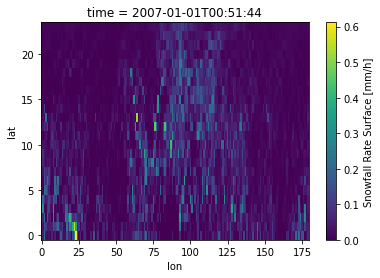

In [10]:
sf_cl.isel(time=0).plot()

In [11]:
from src.utils import quickplot

In [12]:
lons = np.arange(-180, 180, 2)

In [13]:
lats = np.arange(58.5, 82, 1)

In [14]:
glon, glat = np.meshgrid(lons, lats)

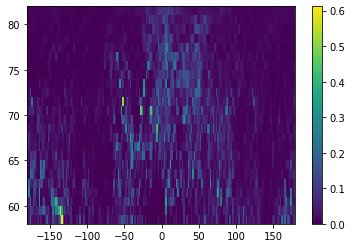

In [15]:
plt.pcolormesh(glon, glat, sf_cl.isel(time=0))
plt.colorbar()

In [16]:
from importlib import reload

In [17]:
reload(quickplot)

<module 'src.utils.quickplot' from '/cluster/home/leoede/tardis/tardis-ml/src/utils/quickplot.py'>

/cluster/home/leoede/tardis/tardis-ml/src/utils/quickplot.py:70: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cs = m.pcolormesh(nlons, nlats, var, **kwargs)


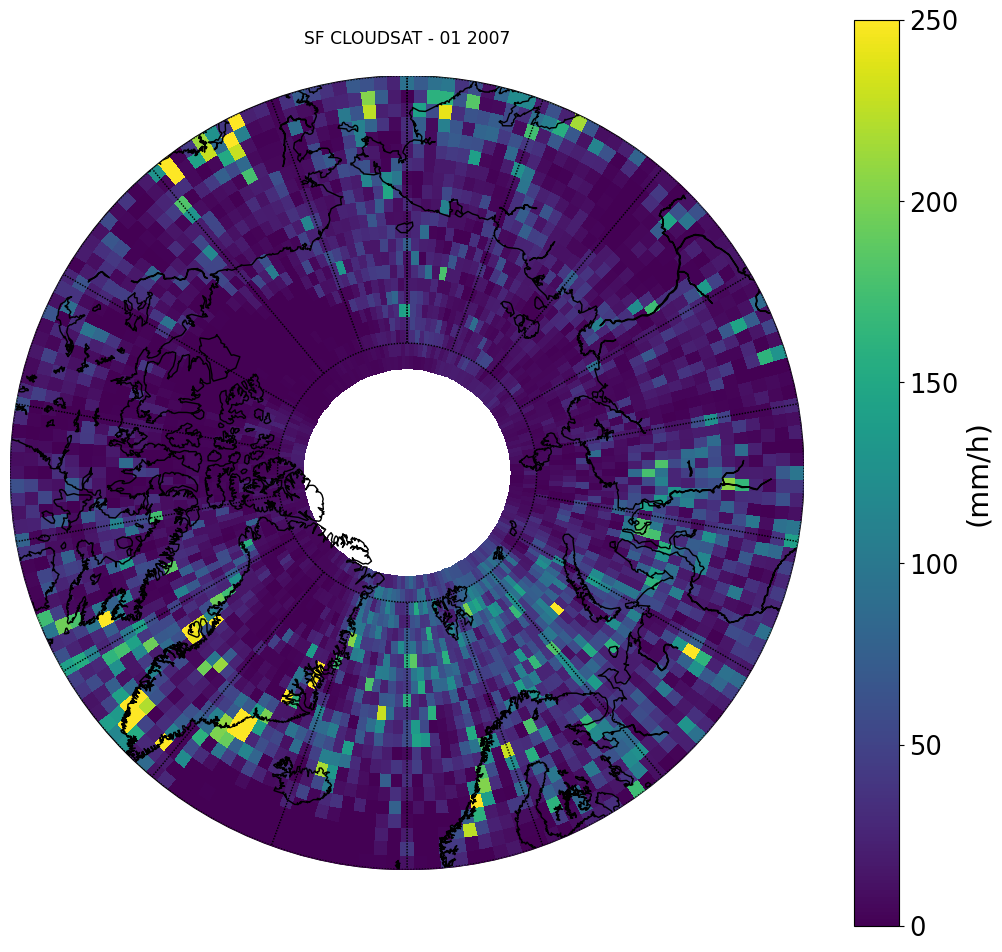

In [18]:
quickplot.basemap_mesh(glon, glat, sf_cl.isel(time=10)*24*31,vmax=250) # 0.2)

In [4]:
from src.data_preparation import load_data

In [2]:
from importlib import reload

In [3]:
reload(load_data)

NameError: name 'load_data' is not defined

In [9]:
# ---------------------------------------------------
#                 Loading data
# ---------------------------------------------------

# too heavy for fram jnb
print('Loading data...')
Xf, Xe, dsCo, dsFo, chrono, maskok = load_data.load_dataset_nc(file_config, train=False, verbose=1)  # , sia, maskok

Loading data...
	Retrieve siconc
	Retrieve sisnthick
	Retrieve vxsi
	Retrieve vysi
	Retrieve zos
Load forcings 10U_mean29d between 2000-2011
pas encore bugge
Loading sia...


In [1]:
from importlib import reload

In [2]:
reload(load_data)

NameError: name 'load_data' is not defined

In [43]:
reload(mdl_dataset)

<module 'src.data_preparation.mdl_dataset' from '/cluster/home/leoede/tardis/tardis-ml/src/data_preparation/mdl_dataset.py'>

In [18]:
Xf.shape

(4383, 329, 450)

In [15]:
snthick.shape

(4383, 329, 450)

In [12]:
dsFo['10U_mean29d'][:,:].shape

(4383, 329, 450)

In [34]:
# we want
# ERA5 precip (solid only ?) over sea ice (TP4b freerun)
# ERA5 cumulative snowfall (over which period)
# snsithick in TOPAZ4 (4b freerun)

In [35]:
snthick = dsCo['sisnthick']

tp = xr.DataArray(data=dsFo['TP_mean29d'][:,:], coords=snthick.coords)
t2 = xr.DataArray(data=dsFo['2T_mean29d'][:,:], coords=snthick.coords)

ValueError: conflicting sizes for dimension 'time': length 365 on the data but length 4383 on coordinate 'time'

In [ ]:
# snowfall
sf = tp.where(t2<273.15, 0)  # precip only solid
sf = sf.where(Xf>0.0, 0)  # over SIT >0

In [12]:
# compute cumul precip
sf_cum = sf.cumsum(dim='time')

In [13]:

def cumsum_15sept(arr):
    '''snowfall cumulative is reset the 15th september
    '''

    new_arr = np.zeros((arr.shape))
    
    years = np.unique([dt.year for dt in chrono_dt])  # get present years
    days_15sept = [datetime.datetime(year, 9, 15) for year in years]  # all 15 sept to check
    idx_15sept = [np.where(chrono_dt==day.date())[0] for day in days_15sept]  # get indexes
    # clean: list of array containing indexes to list of indexes
    idx_cl = [arr[0] if arr.size == 1 else None for arr in idx_15sept]

    # compute sum and iterate over N years (N 15sept)
    for idx0, idx1 in zip(idx_cl[:-1],idx_cl[1:]):
#         print(idx0, idx1)
        new_arr[idx0:idx1] = arr.isel(time=slice(idx0,idx1)).cumsum(dim='time')
    
    return xr.DataArray(data=new_arr, coords=arr.coords)
    

In [71]:
def sumcum_nval(arr, ndays=31):
    '''cum sum over the last month
    arr    : DataArray, dims= (time, y, x)
    '''
    new_arr = np.zeros((arr.shape))
    
    for t in range(arr.shape[0]):
        print(t)
        new_arr[t] = arr.isel(time=slice(t-ndays, t)).sum(dim='time')
    
    return xr.DataArray(data=new_arr, dims=arr.dims)
    
    

In [72]:
sf_cum1m = sumcum_nval(sf)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065


In [73]:
# remove land precip
sf = sf.where(maskok)
# sf_cum = sf_cum.where(maskok)
# sf_cum15 = sf_cum15.where(maskok)

In [74]:
sf_cum1m = sf_cum1m.where(maskok)

In [18]:
import matplotlib.pyplot as plt
from src.utils import save_name
from src.utils import modif_plot

In [99]:
import datetime

In [100]:
day = datetime.datetime(2012, 9, 14)

In [21]:
fig_dir = 'Leo/results/bin_fig/sf_ERA5_cum1m/'

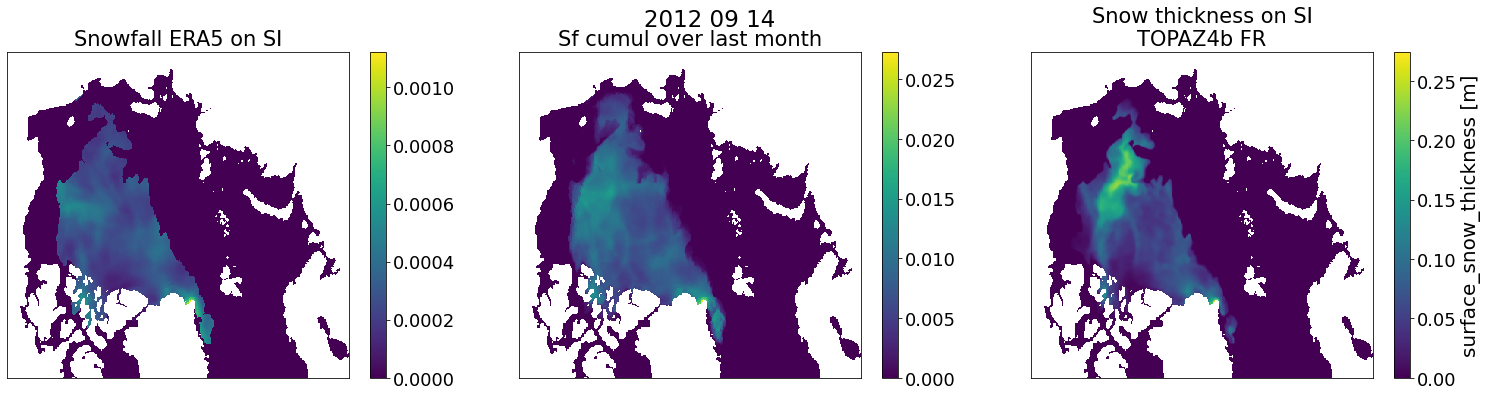

In [27]:
draw_3sf(sf, sf_cum1m, snthick, chrono, day, rootdir, fig_dir, showfig=True, savefig=False)

In [28]:
# plot all test period
d1 = datetime.datetime(2011,10,1)
# d2 = datetime.datetime(2012, 10,1)  # 2019,9,15)
d2 = datetime.datetime(2019,9,15)


all_days = np.array([d1 + datetime.timedelta(days=x) for x in range((d2-d1).days + 1)])

In [ ]:
multiple_3sf(sf, sf_cum1m, snthick, chrono, all_days, rootdir, fig_dir)

Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20111001.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20111002.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20111003.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20111004.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20111005.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20111006.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20111007.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20111008.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20111009.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20111010.png
Saved as: /nird/proj

Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20111224.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20111225.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20111226.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20111227.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20111228.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20111229.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20111230.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20111231.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120101.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120102.png
Saved as: /nird/proj

Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120317.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120318.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120319.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120320.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120321.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120322.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120323.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120324.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120325.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120326.png
Saved as: /nird/proj

Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120609.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120610.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120611.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120612.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120613.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120614.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120615.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120616.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120617.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120618.png
Saved as: /nird/proj

Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120901.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120902.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120903.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120904.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120905.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120906.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120907.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120908.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120909.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20120910.png
Saved as: /nird/proj

Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20121124.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20121125.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20121126.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20121127.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20121128.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20121129.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20121130.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20121201.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20121202.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20121203.png
Saved as: /nird/proj

Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130216.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130217.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130218.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130219.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130220.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130221.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130222.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130223.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130224.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130225.png
Saved as: /nird/proj

Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130511.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130512.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130513.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130514.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130515.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130516.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130517.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130518.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130519.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130520.png
Saved as: /nird/proj

Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130803.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130804.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130805.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130806.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130807.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130808.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130809.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130810.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130811.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20130812.png
Saved as: /nird/proj

Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20131026.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20131027.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20131028.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20131029.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20131030.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20131031.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20131101.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20131102.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20131103.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20131104.png
Saved as: /nird/proj

Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20140118.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20140119.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20140120.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20140121.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20140122.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20140123.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20140124.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20140125.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20140126.png
Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum1m/sf_ERA5_TP4b_20140127.png
Saved as: /nird/proj

-----------------------------------

In [183]:
fig_dir = 'Leo/results/bin_fig/sf_ERA5_cum15sept/'

Saved as: /nird/projects/nird/NS2993K/Leo/results/bin_fig/sf_ERA5_cum15sept/sf_ERA5_TP4b_20130914.png


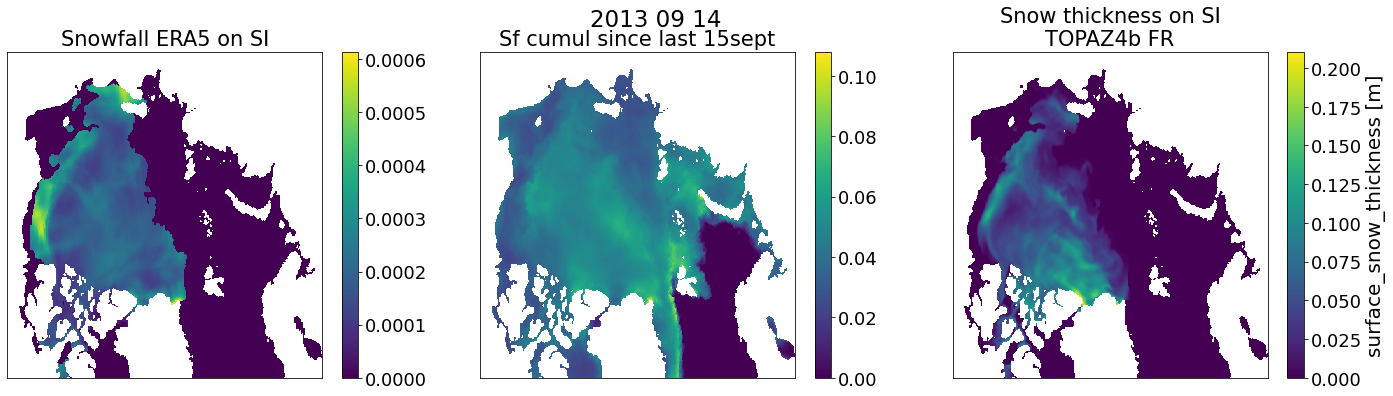

In [189]:
draw_3sf(sf, sf_cum15, snthick, chrono, day, rootdir, fig_dir, showfig=True, savefig=False)

In [24]:
def multiple_3sf(sf, sf_cum, snthick, chrono, days, rootdir, fig_dir, showfig=False, savefig=True):
    '''Run draw_3sf for multiple days
    
    Parameters:
    -----------
    days        :  array of datetime.datetime(yyyy,mm,dd)
    
    
    '''
    
    for day in days:
        draw_3sf(sf, sf_cum, snthick, chrono, day, rootdir, fig_dir, showfig=showfig, savefig=savefig)
    
    print('Finish')

In [23]:
def draw_3sf(sf, sf_cum, snthick, chrono, day, rootdir='', fig_dir='', savefig=False, showfig=False):

     # identify index to plot
    chrono_dt = np.array([dt.date() for dt in chrono.date])
    idx = np.where(chrono_dt==day.date())[0]


#     fig, axes = plt.subplots(ncols=3, figsize=(24,6))
    fig, axes = plt.subplots(ncols=3, figsize=(26,6))
    
    
    sf.isel(time=idx).plot(ax=axes[0])
    sf_cum.isel(time=idx).plot(ax=axes[1])
    snthick.isel(time=idx).plot(ax=axes[2])
    
    
    axes[0].set_title('Snowfall ERA5 on SI')  # (m/d)
#     axes[1].set_title('Sf cumul since last 15sept')
    axes[1].set_title('Sf cumul over last month')  # (meters/month)
    axes[2].set_title('Snow thickness on SI\nTOPAZ4b FR')

    for ax in axes:
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

    fig.suptitle(f'{chrono_dt[idx][0].strftime("%Y %m %d")}') # , y=1.04)   
    modif_plot.resize(fig, s=18)

    if savefig:
        sdate = chrono_dt[idx][0].strftime("%Y%m%d")
        filename = f'sf_ERA5_TP4b_{sdate}.png'
        plt.savefig(f"{rootdir}{fig_dir}{filename}", facecolor='white')
        print(f'Saved as: {rootdir}{fig_dir}{filename}')

    if showfig:
        plt.show()

    plt.close()

In [36]:
from mpl_toolkits.basemap import Basemap

In [54]:
from src.utils import save_name
from src.utils import modif_plot

In [166]:
day = datetime.datetime(2009, 12, 14)

[]
35


/tmp/ipykernel_4734/310174923.py:48: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = m.pcolormesh(mlons, mlats, sit_obs.isel(time=idx_cl), zorder=10, vmax=250, **kwargs)


ValueError: too many values to unpack (expected 2)

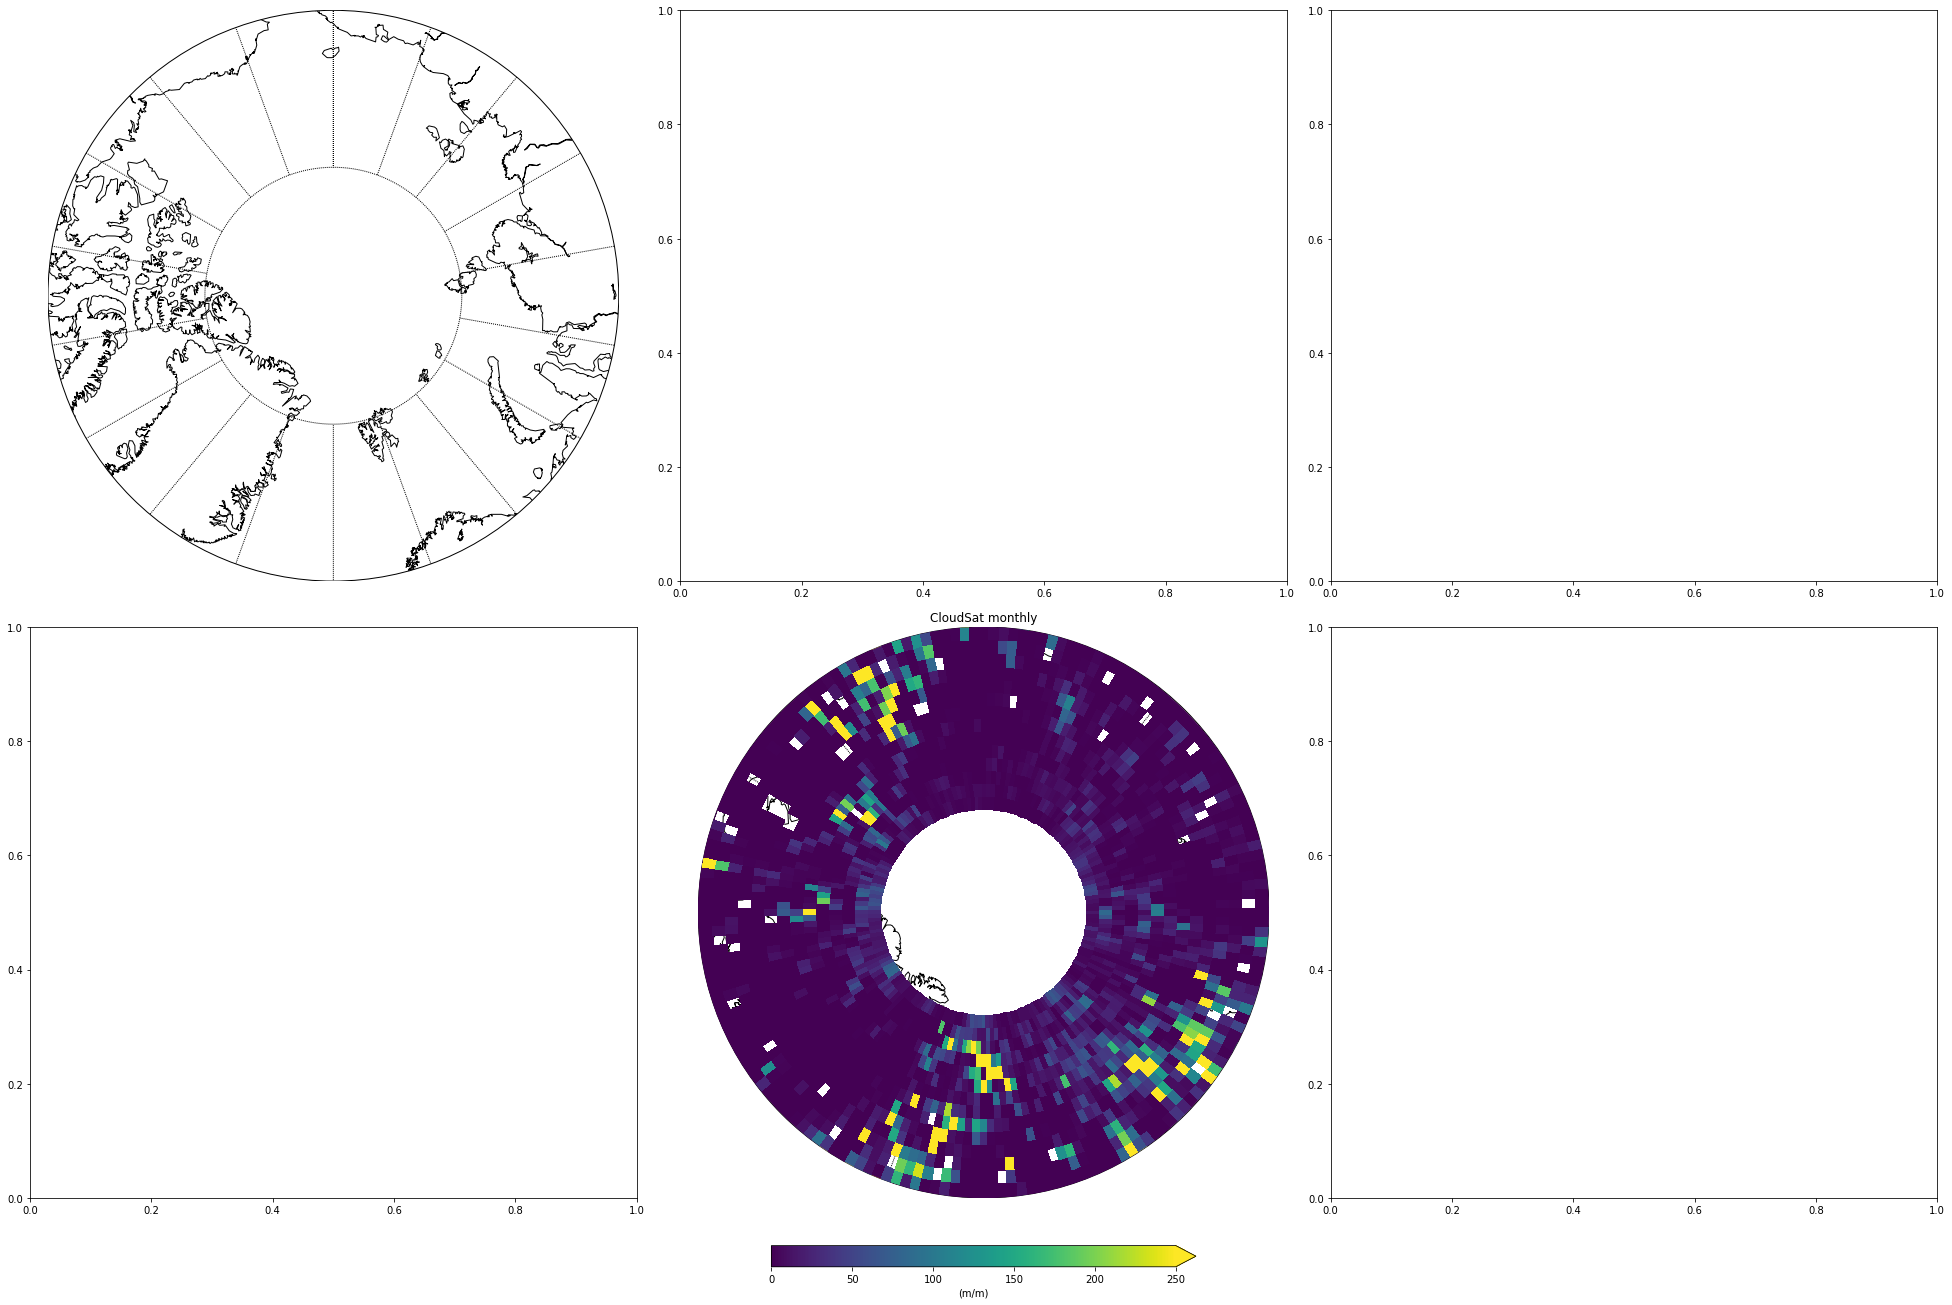

In [184]:
basemap_4sf(glat, glon, sfm_cl,
           sf.latitude, sf.longitude, sf,
           sf.latitude, sf.longitude, sf_cum1m,
           snthick.latitude, snthick.longitude, snthick,
           chrono_cl, chrono, day,
           )

## Plot between 2007-2010 when CloudSat fully in function

In [ ]:
d1 = datetime.datetime(2007,3,22)
d2 = datetime.datetime(2010,12,31)

all_days = np.array([d1 + datetime.timedelta(days=x) for x in range((d2-d1).days + 1)])

In [183]:

def basemap_4sf(lats, lons, sit_obs, lats2, lons2, sit2, 
                lats3, lons3, sit3, lats4, lons4, sit4,
                chrono_cl, chrono, day,
                odir='', savefig=False, showfig=True, **kwargs):
    '''
    Parameters:
    -----------
            lats         :        grid of latitude, dimension from sit_obs
            lons         :        grid of longitude
            sit_obs      :        xr.DataArray, snowfall rates from CloudSat
            lats2        :        grid of latitude, dimension from sit_tp
            lons2        :        grid of longitude
            sit_tp       :        xr.DataArray, Sea Ice Thickness from ToPaz
    
    
    
            chrono_cl    :        pandas.DataFrame, date for monthly values from CloudSat
            chrono       :        pandas.DataFrame, date for daily values from ERA5/TOPAZ
            day          :        datetime object, date to plot
    
    '''
    
    
         # identify index to plot
    chrono_dt = np.array([dt.date() for dt in chrono.date])
    idx = np.where(chrono_dt==day.date())[0]#[0]
    
    print(idx)

    chrono_dt_cl = np.array([dt.date() for dt in chrono_cl.date])
    day_cl = datetime.date(day.year, day.month, 1)
    idx_cl = np.where(chrono_dt_cl==day_cl)[0][0]
    print(idx_cl)
#     if len(idx_cl)==0: idx_cl=[0]

    
    
#     fig = plt.figure(figsize=((1920/103)/1.5,1200/103),dpi=103)
    
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(9*3, 9*2), constrained_layout=True)
    
    m = Basemap(projection='npstere', boundinglat=68, lon_0=0, resolution='l', round=True, ax=axes[1][1])
    m.drawcoastlines()
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    
    mlons, mlats = m(lons, lats)
    
    pcm = m.pcolormesh(mlons, mlats, sit_obs.isel(time=idx_cl), zorder=10, vmax=250, **kwargs)
    # cbar = plt.colorbar(cs)
    # cbar.set_label('{}'.format(label_cb))
    axes[1][1].set_title('CloudSat monthly')
    cbar=fig.colorbar(pcm, ax=axes[1][1], shrink=0.7, location="bottom", extend='max',
                     label='(m/m)') # , pad=-0.43)
    
    
    m2 = Basemap(projection='npstere', boundinglat=68, lon_0=0, resolution='l', round=True, ax=axes[0][0])
    m2.drawcoastlines()
    m2.drawparallels(np.arange(-80.,81.,20.))
    m2.drawmeridians(np.arange(-180.,181.,20.))
    
    mlons2, mlats2 = m2(lons2, lats2)
    
    pcm2 = m2.pcolormesh(mlons2, mlats2, sit2.isel(time=idx)*1000, zorder=10, **kwargs)
    axes[0][0].set_title('Snowfall ERA5 on SI')
    
    cbar=fig.colorbar(pcm2, ax=axes[0][0], shrink=0.7, location="bottom", extend='max',
                     label='(m/d)') # , pad=-0.43)
    
    
    
    m3 = Basemap(projection='npstere', boundinglat=68, lon_0=0, resolution='l', round=True, ax=axes[0][1])
    m3.drawcoastlines()
    m3.drawparallels(np.arange(-80.,81.,20.))
    m3.drawmeridians(np.arange(-180.,181.,20.))
    
    mlons3, mlats3 = m3(lons3, lats3)
    
    pcm3 = m3.pcolormesh(mlons3, mlats3, sit3.isel(time=idx)*1000, zorder=10, **kwargs)
    axes[0][1].set_title('Sf ERA5 cumul over last month')
    
    cbar=fig.colorbar(pcm3, ax=axes[0][1], shrink=0.7, location="bottom", extend='max',
                     label='(meter/month)') # , pad=-0.43)
    
    
    m4 = Basemap(projection='npstere', boundinglat=68, lon_0=0, resolution='l', round=True, ax=axes[0][2])
    m4.drawcoastlines()
    m4.drawparallels(np.arange(-80.,81.,20.))
    m4.drawmeridians(np.arange(-180.,181.,20.))
    
    mlons4, mlats4 = m4(lons4, lats4)
    
    pcm4 = m4.pcolormesh(mlons4, mlats4, sit4.isel(time=idx), zorder=10, **kwargs)
    axes[0][2].set_title('Snow thickness on SI\nTOPAZ4b FR')
    
    cbar=fig.colorbar(pcm4, ax=axes[0][2], shrink=0.7, location="bottom", extend='max',
                     label='(m)') # , pad=-0.43)
    cbar.ax.tick_params(rotation=45)
    
    
    axes[1][0].set_visible(False)
    axes[1][2].set_visible(False)

    
#     fig.suptitle(f'fake date 2014 01 26') # {chrono_dt[idx][0].strftime("%Y %m %d")}') # , y=1.04)   
    fig.suptitle(f'{chrono_dt[idx].strftime("%Y %m %d")}') # , y=1.04)   
    
    
    
    
    
    ### cbar=fig.colorbar(cs2, ax=axes, shrink=0.3, location="bottom", extend='max')
   # cbar=fig.colorbar(cs2, ax=axes, shrink=0.7, location="bottom", extend='max') # , pad=-0.43)
    #cbar.set_label('SIT (m)')
    
    #cbar.set_ticklabels(["0" , '', "1" , '', "2" , '', "3" , '', "4"])  #int(x) for x in cbar.ax.xaxis.get_ticklabels()])
    
#    fig.suptitle(suptitle)
    modif_plot.resize(fig, s=32, rx=20)
#     fig.tight_layout(pad=3)
    
    
    if savefig:        
        sdate = chrono_dt[idx].strftime("%Y%m%d")
        filename = f'sf_ERA5_TP4b_CLDST_{sdate}.png'
        
        ofile = save_name.check(f"{odir}", ofile)
        plt.savefig(f"{odir}{ofile}", dpi=124, facecolor='white')
        print(f'Figure saved as : {odir}{ofile}')
        
    if showfig:
        plt.show()
        
    plt.close()